In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime,timedelta
from copy import deepcopy as dc

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Download data

In [210]:
ticker="EURUSD=X"
current_date = datetime.now()
data: pd.DataFrame = yf.download(ticker,
                                 start=current_date - timedelta(days=730),
                                 end=current_date,
                                 interval="1h")
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-07-04 00:00:00+01:00,1.043732,1.044277,1.043297,1.043623,1.043623,0
2022-07-04 01:00:00+01:00,1.043841,1.044714,1.043515,1.043732,1.043732,0
2022-07-04 02:00:00+01:00,1.043732,1.044168,1.042970,1.043732,1.043732,0
2022-07-04 03:00:00+01:00,1.043515,1.043950,1.042970,1.043515,1.043515,0
2022-07-04 04:00:00+01:00,1.043515,1.044059,1.042862,1.042970,1.042970,0
...,...,...,...,...,...,...
2024-07-02 13:00:00+01:00,1.072846,1.073653,1.072846,1.073422,1.073422,0
2024-07-02 14:00:00+01:00,1.073537,1.074807,1.073422,1.074576,1.074576,0
2024-07-02 15:00:00+01:00,1.074114,1.074576,1.072846,1.074576,1.074576,0


In [211]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12384 entries, 2022-07-04 00:00:00+01:00 to 2024-07-02 17:00:00+01:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       12384 non-null  float64
 1   High       12384 non-null  float64
 2   Low        12384 non-null  float64
 3   Close      12384 non-null  float64
 4   Adj Close  12384 non-null  float64
 5   Volume     12384 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 677.2 KB


# Data processing

In [212]:
data = data.reset_index()
data["Datetime"] = pd.to_datetime(data["Datetime"])
data["Date"] = data["Datetime"].dt.date
data["Time"] = data["Datetime"].dt.hour
data = data.drop(columns=["Volume","Adj Close","Datetime"])
data

,Open,High,Low,Close,Date,Time
0,1.043732,1.044277,1.043297,1.043623,2022-07-04,0
1,1.043841,1.044714,1.043515,1.043732,2022-07-04,1
2,1.043732,1.044168,1.042970,1.043732,2022-07-04,2
3,1.043515,1.043950,1.042970,1.043515,2022-07-04,3
4,1.043515,1.044059,1.042862,1.042970,2022-07-04,4
...,...,...,...,...,...,...
12379,1.072846,1.073653,1.072846,1.073422,2024-07-02,13
12380,1.073537,1.074807,1.073422,1.074576,2024-07-02,14
12381,1.074114,1.074576,1.072846,1.074576,2024-07-02,15
12382,1.074691,1.074691,1.073653,1.073883,2024-07-02,16


In [213]:
def sma(data: pd.DataFrame, period: int):
    data[f"SMA-{period}"] = data["Close"].rolling(window=period).mean()

def std(data: pd.DataFrame, period:int):
    data[f"STD-{period}"] = data["Close"].rolling(window=period).std()

def bb(data: pd.DataFrame, period: int):
    data[f'Lower_BB-{period}'] = data[f"SMA-{period}"] - 2 * data[f"STD-{period}"]
    data[f'Upper_BB-{period}'] = data[f"SMA-{period}"] + 2 * data[f"STD-{period}"]

def ema(data: pd.DataFrame, period: int):
    data[f"EMA-{period}"] = data["Close"].ewm(span=period,adjust=False).mean()

def rsi(data: pd.DataFrame, period: int):
    # 
    delta = data["Close"].diff()
    delta = delta.dropna()

    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0], loss[loss > 0] = 0, 0

    avg_gain = gain.ewm(com=14, min_periods=period).mean()
    avg_loss = abs(loss.ewm(com = 14, min_periods=period).mean())

    data[f"RSI-{period}"] = 100 - (100/(1 + (avg_gain/avg_loss)))


In [214]:
# creating indicators features
period = 20
sma(data,period)
std(data,period)
bb(data,period)
ema(data,period)
#data = data.reset_index(drop=True)
rsi(data,period)

# removing unnecessary features
features = data.columns.tolist()
features.remove("Open")
#features.remove("Date")
#features.remove("Time")
features.remove("Close")
features.append("Close")

############################################
#features.remove("STD-20")
features.remove("EMA-20")
############################################

# selecting features
data = data.dropna()
data = data[features]
data = data.set_index("Date")
data

,High,Low,Time,SMA-20,STD-20,Lower_BB-20,Upper_BB-20,RSI-20,Close
Date,,,,,,,,,
2022-07-04,1.043079,1.042427,20,1.043630,0.001015,1.041600,1.045659,40.953307,1.042644
2022-07-04,1.042862,1.042427,21,1.043570,0.001043,1.041483,1.045657,40.088042,1.042535
2022-07-04,1.042862,1.042210,22,1.043505,0.001073,1.041359,1.045651,39.201599,1.042427
2022-07-04,1.043297,1.042535,23,1.043478,0.001080,1.041318,1.045637,45.647253,1.042970
2022-07-05,1.043841,1.042970,0,1.043510,0.001073,1.041363,1.045657,52.173504,1.043623
...,...,...,...,...,...,...,...,...,...
2024-07-02,1.073653,1.072846,13,1.073273,0.000829,1.071616,1.074930,51.162900,1.073422
2024-07-02,1.074807,1.073422,14,1.073342,0.000878,1.071587,1.075098,57.674337,1.074576
2024-07-02,1.074576,1.072846,15,1.073411,0.000919,1.071574,1.075249,57.674337,1.074576


In [215]:
data = data.to_numpy()
scaler = MinMaxScaler(feature_range=(-1,1))
data = scaler.fit_transform(data)
data


array([[ 0.01162507,  0.03141718,  0.73913043, ...,  0.0177283 ,
        -0.23866916,  0.02835578],
       [ 0.00908632,  0.03141718,  0.82608696, ...,  0.01769463,
        -0.26033029,  0.0270904 ],
       [ 0.00908632,  0.02887927,  0.91304348, ...,  0.01762427,
        -0.28252159,  0.02582641],
       ...,
       [ 0.37916891,  0.38666389,  0.30434783, ...,  0.37488973,
         0.17992696,  0.40000416],
       [ 0.38051688,  0.39607906,  0.39130435, ...,  0.37436589,
         0.05844071,  0.39194572],
       [ 0.3710894 ,  0.39338801,  0.47826087, ...,  0.37322659,
         0.0014434 ,  0.38791928]])

# Defining model

In [216]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
model = RNN(1,4,1)
model

RNN(
  (rnn): RNN(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [217]:
X = data[:, 1:]
y = data[:, 0]

X.shape, y.shape

((12364, 8), (12364,))

In [218]:
split_index = int(len(X) * 0.75)

# splitting the data
X_train, X_test = np.array(X[:split_index]), np.array(X[split_index:])
y_train, y_test = np.array(y[:split_index]), np.array(y[split_index:])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9273, 8), (3091, 8), (9273,), (3091,))

In [219]:
# reshaping the data
num_of_features = X.shape[1]
X_train = X_train.reshape((-1, num_of_features, 1))
X_test = X_test.reshape((-1, num_of_features, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [220]:
num_of_features

8

In [221]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9273, 8, 1), (3091, 8, 1), (9273, 1), (3091, 1))

In [222]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9273, 8, 1]),
 torch.Size([3091, 8, 1]),
 torch.Size([9273, 1]),
 torch.Size([3091, 1]))

In [223]:
class RNNDataset(Dataset):
    def __init__(self, X, y) -> None:
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
train_dataset = RNNDataset(X_train, y_train)
test_dataset = RNNDataset(X_test, y_test)

In [224]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [225]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [226]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [227]:
learning_rate = 0.001
num_epochs = 3
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.189
Batch 200, Loss: 0.065
Batch 300, Loss: 0.019
Batch 400, Loss: 0.005
Batch 500, Loss: 0.002
Batch 600, Loss: 0.002
Batch 700, Loss: 0.001
Batch 800, Loss: 0.001
Batch 900, Loss: 0.001
Batch 1000, Loss: 0.001
Batch 1100, Loss: 0.001

Val Loss: 0.000
***************************************************

Epoch: 2
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.000
Batch 600, Loss: 0.001
Batch 700, Loss: 0.000
Batch 800, Loss: 0.000
Batch 900, Loss: 0.000
Batch 1000, Loss: 0.000
Batch 1100, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Batch 800, Loss: 0.000
Batch 900, Loss: 0.000
Batch 1000, Loss: 0.000
Batch 1100, Loss: 0.000

Val Loss: 0.000
***************************************************

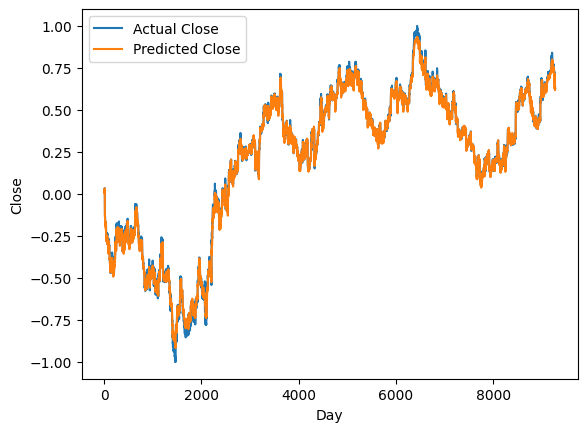

In [228]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [229]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], num_of_features+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([1.04277691, 1.04263778, 1.04249309, ..., 1.09698316, 1.09625696,
       1.09576622])

In [230]:
dummies = np.zeros((X_train.shape[0], num_of_features+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([1.04307914, 1.04286158, 1.04286158, ..., 1.09637094, 1.09601057,
       1.0958904 ])

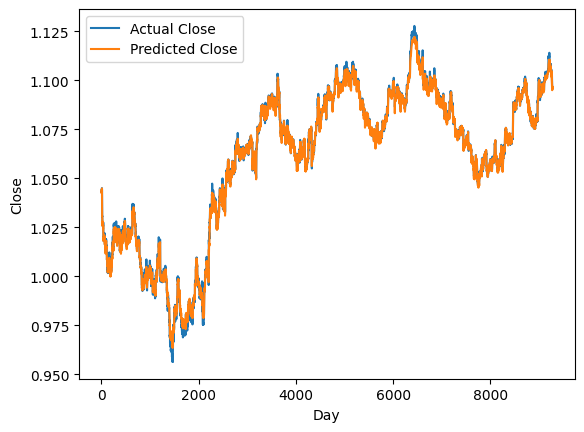

In [231]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [232]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], num_of_features+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1.09552662, 1.09500666, 1.09473048, ..., 1.07534322, 1.07475586,
       1.07440419])

In [233]:
dummies = np.zeros((X_test.shape[0], num_of_features+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1.0952903 , 1.0952903 , 1.09457087, ..., 1.07457554, 1.07469106,
       1.07388318])

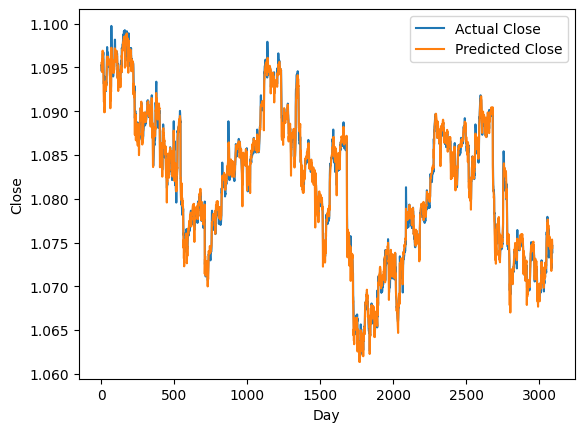

In [234]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [235]:
predicted_price = test_predictions[-1]

In [236]:
def evaluate_model(model, X_test, y_test):
    # Ensure the model is in evaluation mode
    model.eval()

    # Perform the forward pass
    with torch.no_grad():
        predictions = model(X_test)

    # Detach the predictions tensor and convert to numpy
    predictions_np = predictions.detach().numpy()

    return mean_squared_error(y_test, predictions_np)

mse = evaluate_model(model, X_test, y_test)

In [237]:
def get_current_price(symbol:str):
    todays_data = yf.Ticker(symbol).history(period='1d')
    return todays_data['Close'].iloc[0]

current_price = get_current_price(ticker)

In [238]:
print(f'{ticker} Stock Prices')
print(f'\nStock Price Now: {current_price: 0.2f}')
print(f'Predicted Stock Price: {predicted_price: 0.2f}')
print(f'Mean Squared Error on Test Data: {mse: 0.2f}')

EURUSD=X Stock Prices

Stock Price Now:  1.07
Predicted Stock Price:  1.07
Mean Squared Error on Test Data:  0.00
